### Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
# from absl import flags
import tensorflow as tf
import tensorflow_privacy
from keras.models import Model
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image, ImageOps
import tensorflow_addons as tfa
from keras.layers.convolutional import Conv2D
from tensorflow.keras.datasets import cifar10
from tensorflow_addons.layers import GroupNormalization
from keras.layers import Input, Dense, Flatten, Dropout, Add, LayerNormalization
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
tf.compat.v1.disable_v2_behavior()
tf.get_logger().setLevel('ERROR')
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


### Load Dataset

In [2]:
def hog_transform(train):
    train_hog = []
    for sample in train:
        img = Image.fromarray(np.uint8(sample)).convert('RGB')
        img = ImageOps.grayscale(img)
        hog_features = hog(img, orientations = 9, pixels_per_cell = (2, 2), 
                           cells_per_block = (1, 1), block_norm = 'L2', visualize = False)
        train_hog.append(hog_features)
    train_hog = np.array(train_hog)
    return train_hog

In [3]:
# Loading cifar10 image dataset
data_train, data_test = cifar10.load_data()
x_train, y_train = data_train
x_test, y_test = data_test

# # Normalizing pixel values of images
# x_train = x_train / 255.0
# x_test = x_test / 255.0

# Hog transformations of images
x_train_hog = hog_transform(x_train)
x_test_hog = hog_transform(x_test)

# # Flattening images in dataset
# y_train = y_train.flatten().reshape(y_train.shape[0], 1)
# y_test = y_test.flatten().reshape(y_test.shape[0], 1)

# One hot encoding of labels/target column
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("training:", x_train_hog.shape, y_train.shape)
print("testing:", x_test_hog.shape, y_test.shape)

training: (50000, 2304) (50000, 10)
testing: (10000, 2304) (10000, 10)


### Model: HOG + ANN

In [3]:
### Hyper-parameters

# epochs = 130
# batch_size = 500
# l2_norm_clip = 1
# noise_multiplier = 1.3
# num_microbatches = 100
# learning_rate = 0.15
# delta = 1e-5

epochs = 35
batch_size = 1650
l2_norm_clip = 1
noise_multiplier = 1.3
num_microbatches = 150
learning_rate = 0.15
delta = 1e-5

if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    
# Compute RDP
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
rdp = compute_rdp(q = batch_size / 50000,
                  noise_multiplier = noise_multiplier,
                  steps = epochs * 50000 // batch_size,
                  orders = orders)
# Calculate epsilon
epsilon = get_privacy_spent(orders, rdp, target_delta = delta)[0]
epsilon

4.837840947829664

In [17]:
# Feed-forward network
model_input = Input(shape = (2304))
d1 = Dense(16, activation = 'tanh')(model_input)
d1 = Dropout(0.3)(d1)
d2 = Dense(16, activation = 'tanh')(d1)
d3 = LayerNormalization()(d2)
# sk1 = Add()([d1, d3])
d4 = Dense(16, activation = 'tanh')(d3)
d4 = Dropout(0.3)(d4)
d5 = Dense(8, activation = 'tanh')(d4)
# d5 = LayerNormalization()(d5)
d6 = Dense(8, activation = 'tanh')(d5)
model_output = Dense(10, activation = 'softmax')(d5)
model = Model(inputs = model_input, outputs = model_output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2304)]       0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 16)           36880       ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 16)           0           ['dense_12[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 16)           272         ['dropout_4[0][0]']              
                                                                                            

In [18]:
# define optimizer (dp-sgd) 
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# # define optimizer (dp-adam)
# optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate,
#     gradient_accumulation_steps=5)

# define loss function
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [19]:
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# Train model
model.fit(x_train_hog, y_train,
          epochs=epochs,
          validation_data=(x_test_hog, y_test),
          batch_size=batch_size)

Train on 50000 samples, validate on 10000 samples


2022-03-25 10:16:55.864685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-25 10:16:56.616160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50


2022-03-25 10:16:56.889227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-25 10:16:57.046081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - ETA: 0s - loss: 2.5355 - acc: 0.1005

/Users/Mahos/miniforge3/envs/shm_tf/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-03-25 10:19:28.921574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - 152s 3ms/sample - loss: 2.5355 - acc: 0.1005 - val_loss: 2.3355 - val_acc: 0.0998
Epoch 2/50
50000/50000 [==============================] - 119s 2ms/sample - loss: 2.3367 - acc: 0.1179 - val_loss: 2.2291 - val_acc: 0.1427
Epoch 3/50
50000/50000 [==============================] - 120s 2ms/sample - loss: 2.2404 - acc: 0.1491 - val_loss: 2.1525 - val_acc: 0.1704
Epoch 4/50
50000/50000 [==============================] - 119s 2ms/sample - loss: 2.1894 - acc: 0.1647 - val_loss: 2.1183 - val_acc: 0.1731
Epoch 5/50
50000/50000 [==============================] - 119s 2ms/sample - loss: 2.1553 - acc: 0.1688 - val_loss: 2.0941 - val_acc: 0.1808
Epoch 6/50
50000/50000 [==============================] - 126s 3ms/sample - loss: 2.1371 - acc: 0.1749 - val_loss: 2.0832 - val_acc: 0.1915
Epoch 7/50
50000/50000 [==============================] - 125s 3ms/sample - loss: 2.1257 - acc: 0.1748 - val_loss: 2.0785 - val_acc: 0.1878
Epoch 8/50
50000/50000 [=======

KeyboardInterrupt: 

### HOG testing

In [320]:
# x_train_hog = []
# for sample in x_train:
#     hog_features = extract_hog(sample)
#     x_train_hog.append(hog_features)
# x_train_hog = np.array(x_train_hog)

In [307]:
# Image.fromarray(np.uint8(hog_image)) #.resize((300, 300)) #.convert('RGB') 

features: 2304


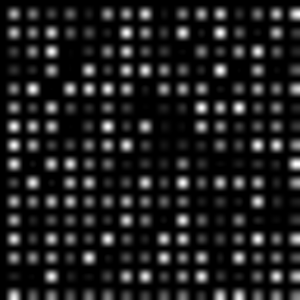

In [319]:
# def extract_hog(sample):
#     img = Image.fromarray(np.uint8(sample)).convert('RGB')
#     img = ImageOps.grayscale(img)
#     hog_features, hog_image = hog(img, orientations = 9, pixels_per_cell = (2, 2),
#                                  cells_per_block = (1, 1), block_norm = 'L2', visualize = True)
#     return hog_features, hog_image
    
# hog_features, hog_image = extract_hog(x_train[0])
# print('features:',len(hog_features))
# # hog_image.reshape(-1)
# thresholded_img = np.array([0 if p == 0 else p*20 for p in hog_image.reshape(-1)]).reshape((32, 32))
# Image.fromarray(np.uint8(thresholded_img)).resize((300, 300))